**Libraries**

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re # stands for "regular expressions." Regular expressions are a powerful tool for matching patterns in text.
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Data Visualization**

In [70]:
path = "/content/drive/MyDrive/DataSet/Proyecto DataSet SVM/Proyecto DataSet/twitter.csv"
Data = pd.read_csv(path, encoding='utf-8')
Data.head(20)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


**Total of Data Points**

In [71]:
num_train = Data.shape[0]
print(f"Number of data points: {num_train}")

Number of data points: 31962


**Split the Data into Training, Validation and Test**

In [72]:
# Split the data into training + development and test sets
train_dev_set, test_set = train_test_split(Data, test_size=0.2, random_state=42)

# Then, split the training + development set into training and development sets
train_set, dev_set = train_test_split(train_dev_set, test_size=0.25, random_state=42)

# Verify the split
train_size = train_set.shape[0]
dev_size = dev_set.shape[0]
test_size = test_set.shape[0]
total_size = Data.shape[0]

print(f"Total data points: {total_size}")
print(f"Training set size: {train_size} ({train_size / total_size * 100:.2f}%)")
print(f"Development set size: {dev_size} ({dev_size / total_size * 100:.2f}%)")
print(f"Test set size: {test_size} ({test_size / total_size * 100:.2f}%)")

Total data points: 31962
Training set size: 19176 (60.00%)
Development set size: 6393 (20.00%)
Test set size: 6393 (20.00%)


**Apply Preprocessing**

In [73]:
def remove_non_ascii(text):
    # This removes everything outside the standard ASCII range
    return re.sub(r'[^\x00-\x7F]+',' ', text)


In [74]:
stop_words = set(stopwords.words('english')) # Remove Stop Words
lemmatizer = WordNetLemmatizer() # Lemmatize Words

def preprocess(text):
    text = text.lower() # Convert Text to Lowercase
    text = remove_non_ascii(text) # Remove Non-ASCII Characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#','', text) # Remove Mentions and Hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove Punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the text columns
train_set['tweet'] = train_set['tweet'].apply(preprocess)
dev_set['tweet'] = dev_set['tweet'].apply(preprocess)
test_set['tweet'] = test_set['tweet'].apply(preprocess)

**Compare Original and Processed Tweet, With a Test Tweet**

In [75]:
test_tweet = "Check this out! https://example.com @user #excited"
print("Original Tweet:", test_tweet)
print("Processed Tweet:", preprocess(test_tweet))

Original Tweet: Check this out! https://example.com @user #excited
Processed Tweet: check excited


**Visualize Word Frequencies**

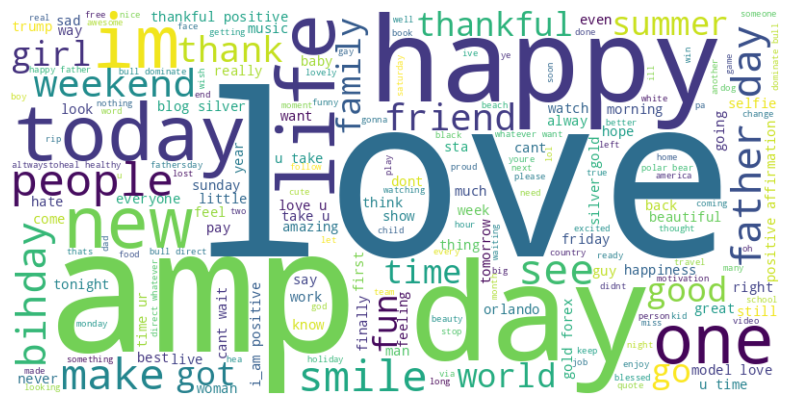

In [76]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(' '.join(train_set['tweet']))

**Bag of Words Model:**

In [77]:
vectorizer = CountVectorizer(binary=True, min_df=5)
X_train = vectorizer.fit_transform(train_set['tweet'])
X_dev = vectorizer.transform(dev_set['tweet'])
X_test = vectorizer.transform(test_set['tweet'])

**Implementation of SVM (Linear Support Vector Classification), Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples**

In [78]:
# Create a pipeline with standard scaling and LinearSVC, but with_mean=False for StandardScaler
model = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=5000))

# Extract the target variable for training, development, and test sets
y_train = train_set['label']
y_dev = dev_set['label']
y_test = test_set['label']

model = LinearSVC(max_iter=5000)  # Increase the number of iteration
# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
predictions = model.predict(X_test)

**Accuracy_Score (In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.) and F1_Macro(It calculates the F1 score for each class independently and then takes the average of these score{MultiClass})**

In [79]:
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy on test set: {accuracy}')

# Calculate F1 score on the test set with macro averaging
f1_macro = f1_score(y_test, predictions, average='macro')
print(f'F1 Macro on test set: {f1_macro}')

Accuracy on test set: 0.9508837791334271
F1 Macro on test set: 0.7968002704738151


**High Accuracy: Your model is performing well overall, correctly predicting the majority of instances.**

**Moderate F1 Macro: While the overall accuracy is high, the F1 Macro score suggests that there might be some imbalance in how well the model is performing across different classes. It indicates that the model might be better at predicting some classes than others.**